## Preparation

In [26]:
# Imports
import json
import torch
import datasets
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [2]:
# Load files
def load_probs(path):
    with open(path, "r") as _file:
        probs = json.load(_file)
    return probs

tiny_mnli_path = "/home/meissner/shortcut-pruning/data/weak_models/tinybert/mnli/tiny-mnli-"
undertrain_mnli_path = "/home/meissner/shortcut-pruning/data/weak_models/undertrained/mnli/undertrain-mnli-"
epochs_comp_path = "/home/meissner/shortcut-pruning/data/weak_models/undertrained/mnli/confidence_exp/epoch-"
tiny_mnlis = [load_probs(tiny_mnli_path + "1" + str(i) + ".json") for i in range(5)]
undertrain_mnlis = [load_probs(undertrain_mnli_path + "1" + str(i) + ".json") for i in range(5)]
undertrain_epochs_comp = [load_probs(epochs_comp_path + str(i) + ".json") for i in range(1,6)]

In [3]:
list(tiny_mnlis[0].items())[:5]

[('0', [0.768073558807373, 0.17574362456798553, 0.056182861328125]),
 ('1', [0.8410807251930237, 0.08569326996803284, 0.07322598248720169]),
 ('2', [0.1369360387325287, 0.665156900882721, 0.1979069858789444]),
 ('3', [0.8453270196914673, 0.07444250583648682, 0.08023039251565933]),
 ('4', [0.8367674350738525, 0.10277853161096573, 0.060453951358795166])]

In [4]:
list(tiny_mnlis[0].values())[:5]

[[0.768073558807373, 0.17574362456798553, 0.056182861328125],
 [0.8410807251930237, 0.08569326996803284, 0.07322598248720169],
 [0.1369360387325287, 0.665156900882721, 0.1979069858789444],
 [0.8453270196914673, 0.07444250583648682, 0.08023039251565933],
 [0.8367674350738525, 0.10277853161096573, 0.060453951358795166]]

In [5]:
tiny_arrays = np.array([list(element.values()) for element in tiny_mnlis])
under_arrays = np.array([list(element.values()) for element in undertrain_mnlis])

In [6]:
tiny_arrays[0][:5]

array([[0.76807356, 0.17574362, 0.05618286],
       [0.84108073, 0.08569327, 0.07322598],
       [0.13693604, 0.6651569 , 0.19790699],
       [0.84532702, 0.07444251, 0.08023039],
       [0.83676744, 0.10277853, 0.06045395]])

## Stability across seeds

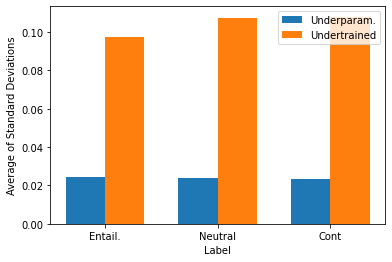

In [7]:
tiny_stdmean, under_stdmean = tiny_arrays.std(axis=0).mean(axis=0), under_arrays.std(axis=0).mean(axis=0)
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
ax.bar(index, tiny_stdmean, bar_width, label="Underparam.")
ax.bar(index+bar_width, under_stdmean, bar_width, label="Undertrained")

ax.set_xlabel('Label')
ax.set_ylabel('Average of Standard Deviations')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(["Entail.", "Neutral", "Cont"])
ax.legend()

plt.show()

## Undertrained vs underparameterized

In [8]:
# Compare average entropy of undertrain vs tiny
tiny_entropies = [np.apply_along_axis(entropy, axis=1, arr=tiny_array) for tiny_array in tiny_arrays]
tiny_entropies = [np.mean(tiny_entropy) for tiny_entropy in tiny_entropies]

KeyboardInterrupt: 

In [ ]:
under_entropies = [np.apply_along_axis(entropy, axis=1, arr=under_array) for under_array in under_arrays]
under_entropies = [np.mean(under_entropy) for under_entropy in under_entropies]

In [ ]:
data = np.array([under_entropies, tiny_entropies]).transpose() # matplotlib wants each vector in one column

In [ ]:
data

In [ ]:
plt.boxplot(data, labels=["Undertrained", "Underparam."])
plt.ylabel("Entropy")
plt.show()

## Undertrained confidence across epochs

In [ ]:
# Plot entropy across epochs
comp_arrays = np.array([list(element.values()) for element in undertrain_epochs_comp])
comp_arrays[0].shape

In [ ]:
comp_entropies = [np.apply_along_axis(entropy, axis=1, arr=array) for array in comp_arrays]
comp_entropies = [np.mean(array) for array in comp_entropies]

In [ ]:
# Taken from Wandb
hans_acc = [0.5559, 0.6413, 0.5716, 0.6087, 0.5927]
m_hard_acc = [0.7473, 0.7571, 0.7434, 0.749, 0.7308]

In [ ]:
plt.plot(range(1,6), comp_entropies)
# plt.xlim([0,6])
plt.xlabel("Train Epochs")
plt.ylabel("Entropy")
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
epochs = range(1,6)

ax1.set_xlabel("Train Epochs")
ax1.set_ylabel("Entropy")
ax1.plot(epochs, comp_entropies, label="Eentropy")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
ax2.set_ylabel('Challenge Set Accuracy')
ax2.plot(epochs, hans_acc, label="HANS", color="slategray")
ax2.plot(epochs, m_hard_acc, label="MNLI Hard", color="brown")

fig.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Weak model subset performance

In [9]:
with open("/home/meissner/shortcut-pruning/data/subsets/mnli_negation_indices.json", "r") as _file:
    indices = json.loads(_file.read())

In [11]:
train_conts = np.array(indices["train_conts"])
train_ents = np.array(indices["train_ents"])
val_conts = np.array(indices["val_m_conts"])
val_ents = np.array(indices["val_m_ents"])

In [12]:
tiny_cont_mean = (tiny_arrays[:, train_conts, :].argmax(axis=2) == 2).mean()

In [13]:
tiny_ent_mean = (tiny_arrays[:, train_ents, :].argmax(axis=2) == 0).mean()

In [14]:
under_cont_mean = (under_arrays[:, train_conts, :].argmax(axis=2) == 2).mean()

In [15]:
under_ent_mean = (under_arrays[:, train_ents, :].argmax(axis=2) == 0).mean()

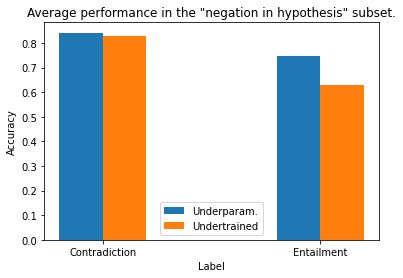

In [16]:
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.20
ax.bar(index, [tiny_cont_mean, tiny_ent_mean], bar_width, label="Underparam.")
ax.bar(index+bar_width, [under_cont_mean, under_ent_mean], bar_width, label="Undertrained")

ax.set_xlabel('Label')
ax.set_ylabel('Accuracy')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(["Contradiction", "Entailment"])
ax.set_title('Average performance in the "negation in hypothesis" subset.')
ax.legend()

plt.show()

## Subset Training Dynamics

In [17]:
# Short + High Precision Run

base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-07/"
batch_size = 32
recording_rate = 20

In [18]:
# Longer and Lower Precision Run

# base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/"
# batch_size = 32
# recording_rate = 200

In [19]:
import glob
train_files = glob.glob(base_path + "train_predictions/*.npy")
val_files = glob.glob(base_path + "val_predictions/*.npy")
num_recordings = len(train_files)

# Sanity check: order of files must be the "natural order"
train_files, val_files

(['/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-07/train_predictions/0.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-07/train_predictions/1.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-07/train_predictions/2.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-07/train_predictions/3.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-07/train_predictions/4.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-07/train_predictions/5.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-

In [20]:
train_preds = [np.load(_file) for _file in train_files]
val_preds = [np.load(_file) for _file in val_files]

In [21]:
steps = [i * batch_size * recording_rate for i in range(num_recordings)]

In [22]:
train_cont_levels = [preds[train_conts, 2].mean() for preds in train_preds]
train_ent_levels = [preds[train_ents, 0].mean() for preds in train_preds]
val_cont_levels = [preds[val_conts, 2].mean() for preds in val_preds]
val_ent_levels = [preds[val_ents, 0].mean() for preds in val_preds]

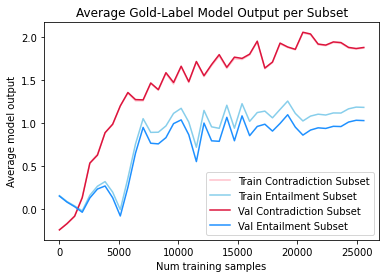

In [24]:
plt.plot(steps, train_cont_levels, label="Train Contradiction Subset", color="pink")
plt.plot(steps, train_ent_levels, label="Train Entailment Subset", color="skyblue")
plt.plot(steps, val_cont_levels, label="Val Contradiction Subset", color="crimson")
plt.plot(steps, val_ent_levels, label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num training samples")
plt.ylabel("Average model output")
plt.title("Average Gold-Label Model Output per Subset")
plt.legend()

In [39]:
train_preds[0].shape, targets.shape

((392702, 3), (9815,))

In [40]:
train_targets = np.array(datasets.load_dataset("glue", "mnli")["train"]["label"])
val_targets = np.array(datasets.load_dataset("glue", "mnli")["validation_matched"]["label"])
train_acc_bools = [train_pred.argmax(axis=1) == train_targets for train_pred in train_preds]
val_acc_bools = [val_pred.argmax(axis=1) == val_targets for val_pred in val_preds]
train_cont_acc = [train_acc_bool[train_conts].mean() for train_acc_bool in train_acc_bools]
train_ent_acc = [train_acc_bool[train_ents].mean() for train_acc_bool in train_acc_bools]
val_cont_acc = [val_acc_bool[val_conts].mean() for val_acc_bool in val_acc_bools]
val_ent_acc = [val_acc_bool[val_ents].mean() for val_acc_bool in val_acc_bools]

Reusing dataset glue (/home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

Reusing dataset glue (/home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

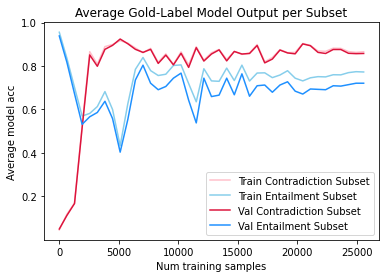

In [42]:
plt.plot(steps, train_cont_acc, label="Train Contradiction Subset", color="pink")
plt.plot(steps, train_ent_acc, label="Train Entailment Subset", color="skyblue")
plt.plot(steps, val_cont_acc, label="Val Contradiction Subset", color="crimson")
plt.plot(steps, val_ent_acc, label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num training samples")
plt.ylabel("Average model acc")
plt.title("Average Gold-Label Model Output per Subset")
plt.legend()

## Worst 10%

In [ ]:
train_dfs = [pd.DataFrame(array) for array in train_preds]
val_dfs = [pd.DataFrame(array) for array in val_preds]

In [ ]:
for df in train_dfs:
    df.loc[train_conts, "label"] = "contradiction"
    df.loc[train_conts, "gold_pred"] = df[2]
    df.loc[train_ents, "label"] = "entailment"
    df.loc[train_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)
    
for df in val_dfs:
    df.loc[val_conts, "label"] = "contradiction"
    df.loc[val_conts, "gold_pred"] = df[2]
    df.loc[val_ents, "label"] = "entailment"
    df.loc[val_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)

In [ ]:
percent = 0.1
negation_train_count = len(train_conts) + len(train_ents)
negation_val_count = len(val_conts) + len(val_ents)
negation_train_count, negation_val_count

In [ ]:
train_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_train_count)).groupby("label").count() for df in train_dfs]
val_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_val_count)).groupby("label").count() for df in val_dfs]

In [ ]:
plt.rcParams["figure.figsize"] = (9,5)
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_train_count) if 'contradiction' in series.index else 0 for series in train_worst], label="Train Contradiction Subset", color="pink")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_train_count) if 'entailment' in series.index else 0 for series in train_worst], label="Train Entailment Subset", color="skyblue")
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_val_count) if 'contradiction' in series.index else 0 for series in val_worst], label="Val Contradiction Subset", color="crimson")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_val_count) if 'entailment' in series.index else 0 for series in val_worst], label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num. Train Samples")
plt.ylabel("Percent Samples in Worst")
plt.title("Percent of Samples in the Worst 10% by Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()

## Check Training Dynamics (old)

In [ ]:
base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/"
train_preds = [np.load(_file) for _file in [base_path + "train_predictions/" f"{step}.npy" for step in range(0, 31, 1)]]
val_preds = [np.load(_file) for _file in [base_path + "val_predictions/" f"{step}.npy" for step in range(0, 31, 1)]]

In [ ]:
len(train_preds), train_preds[0].shape

In [ ]:
len(val_preds), val_preds[0].shape

In [ ]:
train_preds[0][train_conts, 0].mean()

In [ ]:
val_preds[0][val_conts, 0].mean()

In [ ]:
train_cont_levels = [preds[train_conts, 2].mean() for preds in train_preds]
train_ent_levels = [preds[train_ents, 0].mean() for preds in train_preds]
val_cont_levels = [preds[val_conts, 2].mean() for preds in val_preds]
val_ent_levels = [preds[val_ents, 0].mean() for preds in val_preds]

In [ ]:
steps = [i*32*200 for i in range(len(train_preds))]

In [ ]:
plt.plot(steps, train_cont_levels, label="Train Cont Subset")
plt.plot(steps, train_ent_levels, label="Train Entail Subset")
plt.plot(steps, val_cont_levels, label="Val Cont Subset")
plt.plot(steps, val_ent_levels, label="Val Entail Subset")
plt.xlabel("Training samples")
plt.title("Average gold-label probability prediction per subset")
plt.legend()

In [ ]:
train_dfs = [pd.DataFrame(array) for array in train_preds]
# train_dfs = [df[train_conts]["label"] = "contradiction" for df in train_dfs]
# train_dfs = [df[train_ents]["label"] = "entailment" for df in train_dfs]

In [ ]:
for df in train_dfs:
    df.loc[train_conts, "label"] = "contradiction"
    df.loc[train_conts, "gold_pred"] = df[2]
    df.loc[train_ents, "label"] = "entailment"
    df.loc[train_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)

In [ ]:
percent = 0.1
negation_train_count = len(train_conts) + len(train_ents)
negation_val_count = len(val_conts) + len(val_ents)
negation_train_count, negation_val_count

In [ ]:
train_worst = [df.sort_values("gold_pred", ascending=True).head(int(0.3 * len(train_dfs))).groupby("label").count().unstack(fill_value=0).stack() for df in train_dfs]

In [ ]:
'contradiction' in train_worst[30].index

In [ ]:
plt.rcParams["figure.figsize"] = (9,5)
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_train_count) if 'contradiction' in series.index else 0 for series in train_worst], label="Train Contradiction Subset", color="pink")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_train_count) if 'entailment' in series.index else 0 for series in train_worst], label="Train Entailment Subset", color="skyblue")
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_val_count) if 'contradiction' in series.index else 0 for series in val_worst], label="Val Contradiction Subset", color="crimson")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_val_count) if 'entailment' in series.index else 0 for series in val_worst], label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num. Train Samples")
plt.ylabel("Percent Samples in Worst")
plt.title("Percent of Samples in the Worst 10% by Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
train_pds = [pd.concat(df[train